In [131]:
import os
import torch
import argparse
import numpy as np
import torch.utils.data

from torch import nn, optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt
%matplotlib inline

class AutoEncoder(nn.Module):
    def __init__(self, inp_size, hid_size, depth = 3, add_drop=True):
        super(AutoEncoder, self).__init__()
        """
        Here you should define layers of your autoencoder
        Please note, if a layer has trainable parameters, it should be nn.Linear. 
        ## !! CONVOLUTIONAL LAYERS CAN NOT BE HERE !! ##
        However, you can use any noise inducing layers, e.g. Dropout.

        Your network must not have more than six layers with trainable parameters.
        :param inp_size: integer, dimension of the input object
        :param hid_size: integer, dimension of the hidden representation
        """
        
        # Encoder
        self.encoder = nn.Sequential()
        self.encoder.add_module('fc1', nn.Linear(inp_size, ((inp_size + hid_size)*(depth-1))//depth))
        self.encoder.add_module('ReLU1', nn.ReLU())
        
        if add_drop:
            self.encoder.add_module('Drop1', nn.Dropout())
        for i in range(1, depth-1):
            self.encoder.add_module('fc{}'.format(i+1),
                                    nn.Linear(((inp_size + hid_size)*(depth - i))//depth, 
                                              (inp_size + hid_size)*(depth - i - 1)//depth))
            self.encoder.add_module('ReLU{}'.format(i+1), nn.ReLU())
#             if add_drop:
#                 self.encoder.add_module('Drop{}'.format(i+1), nn.Dropout())
                
        self.encoder.add_module('fc{}'.format(depth),  nn.Linear((inp_size + hid_size)//depth, hid_size))
        self.encoder.add_module('ReLU', nn.ReLU())
            
        # Decoder
        self.decoder = nn.Sequential( )
        self.decoder.add_module('fc{}'.format(depth + 1), nn.Linear(hid_size, (inp_size + hid_size)//depth))
        self.decoder.add_module('ReLU1', nn.ReLU())      
        if add_drop:
            self.decoder.add_module('Drop1', nn.Dropout())
            
        for i in range(1, depth):
            self.decoder.add_module('fc{}'.format(depth + i+1),
                                    nn.Linear(((inp_size + hid_size)*i)//depth, (inp_size + hid_size)*(i + 1)//depth))
            self.decoder.add_module('ReLU{}'.format(depth + i+1), nn.ReLU())
#             if add_drop:
#                 self.decoder.add_module('Drop{}'.format(depth + i+1), nn.Dropout())
                
        self.decoder.add_module('fc{}'.format(2*depth),
                                nn.Linear(((inp_size + hid_size)*(depth-1))//depth, inp_size))
        self.decoder.add_module('ReLU{}'.format(2*depth), nn.ReLU())
                  
                                                
        self.add_drop = add_drop

    def encode(self, x):
        """
        Encodes objects to hidden representations (E: R^inp_size -> R^hid_size)

        :param x: inputs, Variable of shape (batch_size, inp_size)
        :return:  hidden represenation of the objects, Variable of shape (batch_size, hid_size)
        """
        return self.encoder(x)

    def decode(self, h):
        """
        Decodes objects from hidden representations (D: R^hid_size -> R^inp_size)

        :param h: hidden represenatations, Variable of shape (batch_size, hid_size)
        :return:  reconstructed objects, Variable of shape (batch_size, inp_size)
        """
#         x = nn.functional.relu(self.fc4(h))
#         if self.add_drop:
#             x = self.drop(x)
#         x = nn.functional.relu(self.fc5(x))
#         if self.add_drop:
#             x = self.drop(x)
#         x = nn.functional.relu(self.fc6(x))
        return self.decoder(h)

    def forward(self, x):
        """
        Encodes inputs to hidden representations and decodes back.

        x: inputs, Variable of shape (batch_size, inp_size)
        return: reconstructed objects, Variable of shape (batch_size, inp_size)
        """
        return self.decoder(self.encoder(x))

    def loss_function(self, recon_x, x, lam = 1e-4, reg='l1', loss='l2'):
        """
        Calculates the loss function.

        :params recon_x: reconstructed object, Variable of shape (batch_size, inp_size)
        :params x: original object, Variable of shape (batch_size, inp_size)
        :return: loss
        """
#         l1_params = torch.sum(torch.FloatTensor([torch.norm(params, p = 1) for params in self.parameters()]))
        l1_crit = nn.L1Loss(size_average=False)
#         l2_crit = nn.MSELoss()
        reg_sum = 0
        for param in self.parameters():
            if reg == 'l1':
                reg_sum += l1_crit(param, target=torch.zeros_like(param))
#             elif reg == 'l2':
#                 reg_sum += l2_crit(param, target=torch.zeros_like(param))
#             elif reg == 'elastic_net':
#                 reg_sum += l1_crit(param, target=torch.zeros_like(param)) + l2_crit(param, target=torch.zeros_like(param))
                
        if loss == 'l2':
            loss = torch.sum(torch.pow(recon_x - x,2)) / recon_x.shape[0]
        elif loss == 'l1':
            loss = l1_crit(recon_x, x)
            
        return loss + lam * reg_sum


In [132]:
aa = AutoEncoder(inp_size = 100, hid_size = 10, depth = 5)
aa.decoder

Sequential(
  (fc6): Linear(in_features=10, out_features=22, bias=True)
  (ReLU1): ReLU()
  (Drop1): Dropout(p=0.5)
  (fc7): Linear(in_features=22, out_features=44, bias=True)
  (ReLU7): ReLU()
  (fc8): Linear(in_features=44, out_features=66, bias=True)
  (ReLU8): ReLU()
  (fc9): Linear(in_features=66, out_features=88, bias=True)
  (ReLU9): ReLU()
  (fc10): Linear(in_features=88, out_features=100, bias=True)
  (ReLU10): ReLU()
)

In [121]:
def train(model, optimizer, train_loader, test_loader, loss_param, n_ep = 10):
    for epoch in range(n_ep):
        model.train()
        train_loss, test_loss = 0, 0
        for data, _ in train_loader:
            data = Variable(data).view(-1, 784)
            x_rec = model(data)
            loss = model.loss_function(x_rec, data, **loss_param)
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.data[0]
        print('=> Epoch: %s Average loss: %.3f' % (epoch, train_loss / len(train_loader.dataset)))

        model.eval()
        for data, _ in test_loader:
            data = Variable(data, volatile=True).view(-1, 784)
            x_rec = model(data)
            test_loss += model.loss_function(x_rec, data, **loss_param).data[0]

        test_loss /= len(test_loader.dataset)
        print('=> Test set loss: %.3f' % test_loss)

        n = min(data.size(0), 8)
        comparison = torch.cat([data.view(-1, 1, 28, 28)[:n], x_rec.view(-1, 1, 28, 28)[:n]])
        if not os.path.exists('./pics'): os.makedirs('./pics')
        res = comparison.data.cpu()
        save_image(res, 'pics/reconstruction_' + str(epoch) + '.png', nrow=n)
    plt.figure(figsize=[12,4])
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(res[i][0])
    return model

**Baseline**
* 6 fc layers (3 for encoder, 3 for decoder)
* Number of neurons decrease/increase gradually (by 1/3)
* $L_2$ loss with $L_1$ regularization
* 2 dropouts

** Variations**

Reconstruction Loss:
* $L_2$
* $L_1$
    
Regularization:
* $L_1$
* $L_2$
* Elastic Net (both)

More Layers:

More neurons:

Dropout:



In [115]:
get_loader = lambda train: torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=train, download=True, transform=transforms.ToTensor()),
    batch_size=50, shuffle=True)
train_loader, test_loader = get_loader(True), get_loader(False)

### With Dropout

=> Epoch: 0 Average loss: 0.616
=> Test set loss: 0.419
=> Epoch: 1 Average loss: 0.478
=> Test set loss: 0.389
=> Epoch: 2 Average loss: 0.455
=> Test set loss: 0.375
=> Epoch: 3 Average loss: 0.444
=> Test set loss: 0.373
=> Epoch: 4 Average loss: 0.437
=> Test set loss: 0.377
=> Epoch: 5 Average loss: 0.431
=> Test set loss: 0.373
=> Epoch: 6 Average loss: 0.427
=> Test set loss: 0.375
=> Epoch: 7 Average loss: 0.424
=> Test set loss: 0.381
=> Epoch: 8 Average loss: 0.422
=> Test set loss: 0.377
=> Epoch: 9 Average loss: 0.419
=> Test set loss: 0.378


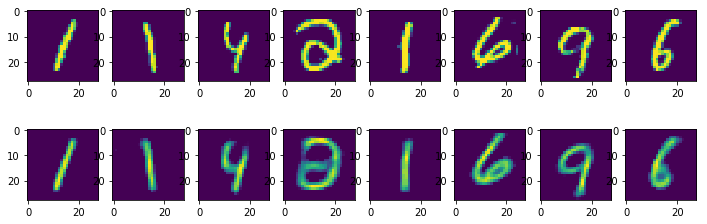

In [123]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l2'}, n_ep  = 10)

### Without dropout

=> Epoch: 0 Average loss: 0.444
=> Test set loss: 0.291
=> Epoch: 1 Average loss: 0.268
=> Test set loss: 0.245
=> Epoch: 2 Average loss: 0.235
=> Test set loss: 0.223
=> Epoch: 3 Average loss: 0.217
=> Test set loss: 0.210
=> Epoch: 4 Average loss: 0.208
=> Test set loss: 0.204
=> Epoch: 5 Average loss: 0.201
=> Test set loss: 0.202
=> Epoch: 6 Average loss: 0.197
=> Test set loss: 0.197
=> Epoch: 7 Average loss: 0.193
=> Test set loss: 0.193
=> Epoch: 8 Average loss: 0.190
=> Test set loss: 0.193
=> Epoch: 9 Average loss: 0.187
=> Test set loss: 0.188


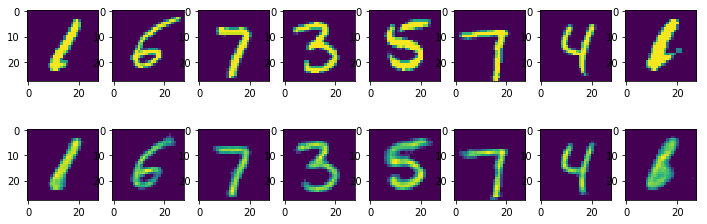

In [124]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = False)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l2'}, n_ep  = 10)

Both training and testing loss are lower without dropout. From the visual perspective I do not see much difference.

### $L_1$ loss without dropout

=> Epoch: 0 Average loss: 67.472
=> Test set loss: 58.908
=> Epoch: 1 Average loss: 55.276
=> Test set loss: 51.838
=> Epoch: 2 Average loss: 49.954
=> Test set loss: 48.778
=> Epoch: 3 Average loss: 47.412
=> Test set loss: 46.093
=> Epoch: 4 Average loss: 45.274
=> Test set loss: 44.539
=> Epoch: 5 Average loss: 42.884
=> Test set loss: 41.201
=> Epoch: 6 Average loss: 40.318
=> Test set loss: 39.777
=> Epoch: 7 Average loss: 39.316
=> Test set loss: 39.354
=> Epoch: 8 Average loss: 38.427
=> Test set loss: 38.076
=> Epoch: 9 Average loss: 37.613
=> Test set loss: 37.162
=> Epoch: 10 Average loss: 36.716
=> Test set loss: 36.815
=> Epoch: 11 Average loss: 36.215
=> Test set loss: 36.386
=> Epoch: 12 Average loss: 35.758
=> Test set loss: 35.831
=> Epoch: 13 Average loss: 35.091
=> Test set loss: 34.893
=> Epoch: 14 Average loss: 34.455
=> Test set loss: 34.862
=> Epoch: 15 Average loss: 34.248
=> Test set loss: 34.652
=> Epoch: 16 Average loss: 34.009
=> Test set loss: 34.449
=> Epoc

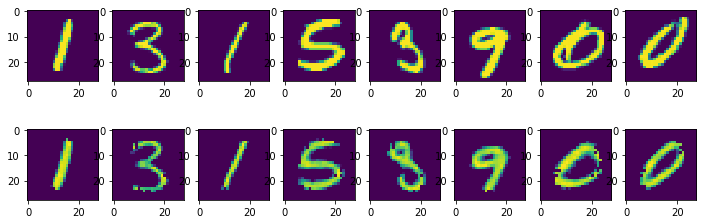

In [137]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = False)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l1'}, n_ep  = 20)

When we use $L_1$ loss instead of the $L_2$ (the only difference between 2 previous models), the reconstruction becomes less blur, but we obtain "dead pixels". 

### $L_1$ loss with dropout

=> Epoch: 0 Average loss: 74.078
=> Test set loss: 63.706
=> Epoch: 1 Average loss: 64.347
=> Test set loss: 58.369
=> Epoch: 2 Average loss: 60.935
=> Test set loss: 55.510
=> Epoch: 3 Average loss: 58.442
=> Test set loss: 53.057
=> Epoch: 4 Average loss: 56.427
=> Test set loss: 50.516
=> Epoch: 5 Average loss: 54.569
=> Test set loss: 49.140
=> Epoch: 6 Average loss: 53.356
=> Test set loss: 47.783
=> Epoch: 7 Average loss: 52.190
=> Test set loss: 46.726
=> Epoch: 8 Average loss: 51.308
=> Test set loss: 45.983
=> Epoch: 9 Average loss: 50.294
=> Test set loss: 44.332
=> Epoch: 10 Average loss: 49.481
=> Test set loss: 43.536
=> Epoch: 11 Average loss: 48.876
=> Test set loss: 42.855
=> Epoch: 12 Average loss: 48.252
=> Test set loss: 42.490
=> Epoch: 13 Average loss: 47.995
=> Test set loss: 42.216
=> Epoch: 14 Average loss: 47.452
=> Test set loss: 41.693
=> Epoch: 15 Average loss: 47.088
=> Test set loss: 41.032
=> Epoch: 16 Average loss: 46.676
=> Test set loss: 40.888
=> Epoc

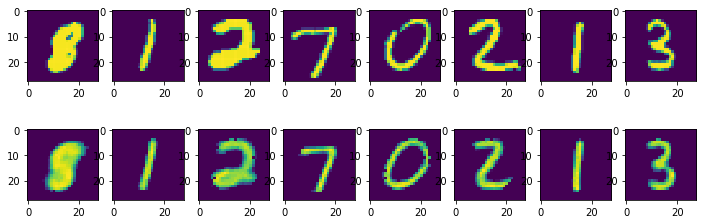

In [140]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l1'}, n_ep  = 30)

### $L_2$ loss without dropout $L_2$ regularisation

=> Epoch: 0 Average loss: 0.593
=> Test set loss: 0.405
=> Epoch: 1 Average loss: 0.439
=> Test set loss: 0.335
=> Epoch: 2 Average loss: 0.405
=> Test set loss: 0.314
=> Epoch: 3 Average loss: 0.390
=> Test set loss: 0.301
=> Epoch: 4 Average loss: 0.381
=> Test set loss: 0.306
=> Epoch: 5 Average loss: 0.374
=> Test set loss: 0.306
=> Epoch: 6 Average loss: 0.368
=> Test set loss: 0.299
=> Epoch: 7 Average loss: 0.364
=> Test set loss: 0.298
=> Epoch: 8 Average loss: 0.360
=> Test set loss: 0.301
=> Epoch: 9 Average loss: 0.357
=> Test set loss: 0.304


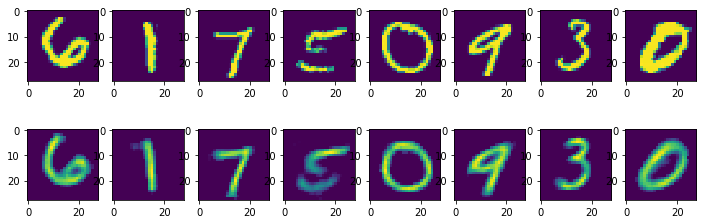

In [129]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l2', 'loss':'l2'}, n_ep  = 10)

### $L_2$ loss without dropout elastic net regularisation

=> Epoch: 0 Average loss: 0.602
=> Test set loss: 0.401
=> Epoch: 1 Average loss: 0.458
=> Test set loss: 0.354
=> Epoch: 2 Average loss: 0.429
=> Test set loss: 0.327
=> Epoch: 3 Average loss: 0.413
=> Test set loss: 0.317
=> Epoch: 4 Average loss: 0.404
=> Test set loss: 0.314
=> Epoch: 5 Average loss: 0.396
=> Test set loss: 0.304
=> Epoch: 6 Average loss: 0.391
=> Test set loss: 0.298
=> Epoch: 7 Average loss: 0.386
=> Test set loss: 0.307
=> Epoch: 8 Average loss: 0.382
=> Test set loss: 0.305
=> Epoch: 9 Average loss: 0.378
=> Test set loss: 0.318


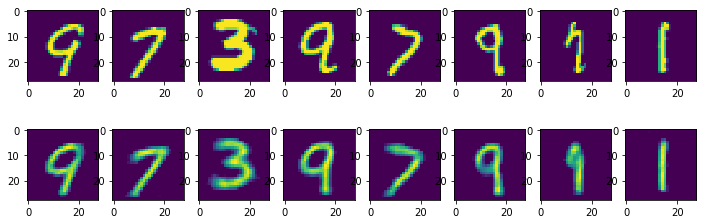

In [134]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = True)
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l2'}, n_ep  = 10)

### More layers (10 layers instead of 6)

=> Epoch: 0 Average loss: 0.804
=> Test set loss: 0.653
=> Epoch: 1 Average loss: 0.532
=> Test set loss: 0.475
=> Epoch: 2 Average loss: 0.458
=> Test set loss: 0.445
=> Epoch: 3 Average loss: 0.437
=> Test set loss: 0.432
=> Epoch: 4 Average loss: 0.412
=> Test set loss: 0.391
=> Epoch: 5 Average loss: 0.386
=> Test set loss: 0.382
=> Epoch: 6 Average loss: 0.375
=> Test set loss: 0.370
=> Epoch: 7 Average loss: 0.366
=> Test set loss: 0.365
=> Epoch: 8 Average loss: 0.357
=> Test set loss: 0.359
=> Epoch: 9 Average loss: 0.347
=> Test set loss: 0.346
=> Epoch: 10 Average loss: 0.337
=> Test set loss: 0.335
=> Epoch: 11 Average loss: 0.331
=> Test set loss: 0.332
=> Epoch: 12 Average loss: 0.326
=> Test set loss: 0.329
=> Epoch: 13 Average loss: 0.322
=> Test set loss: 0.322
=> Epoch: 14 Average loss: 0.316
=> Test set loss: 0.317
=> Epoch: 15 Average loss: 0.308
=> Test set loss: 0.310
=> Epoch: 16 Average loss: 0.300
=> Test set loss: 0.301
=> Epoch: 17 Average loss: 0.293
=> Test 

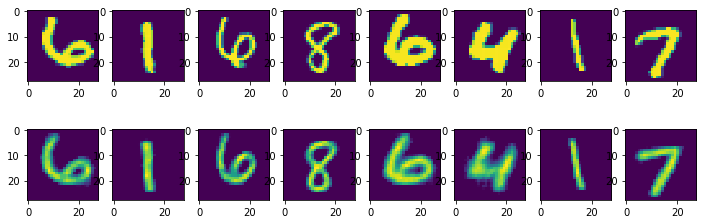

In [138]:
model = AutoEncoder(inp_size=784, hid_size=20, add_drop = False, depth = 5)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l2'}, n_ep  = 20)

### Larger hidden size

=> Epoch: 0 Average loss: 0.424
=> Test set loss: 0.268
=> Epoch: 1 Average loss: 0.235
=> Test set loss: 0.207
=> Epoch: 2 Average loss: 0.198
=> Test set loss: 0.181
=> Epoch: 3 Average loss: 0.179
=> Test set loss: 0.172
=> Epoch: 4 Average loss: 0.168
=> Test set loss: 0.166
=> Epoch: 5 Average loss: 0.160
=> Test set loss: 0.158
=> Epoch: 6 Average loss: 0.153
=> Test set loss: 0.152
=> Epoch: 7 Average loss: 0.148
=> Test set loss: 0.149
=> Epoch: 8 Average loss: 0.143
=> Test set loss: 0.145
=> Epoch: 9 Average loss: 0.140
=> Test set loss: 0.141
=> Epoch: 10 Average loss: 0.137
=> Test set loss: 0.136
=> Epoch: 11 Average loss: 0.135
=> Test set loss: 0.137
=> Epoch: 12 Average loss: 0.132
=> Test set loss: 0.133
=> Epoch: 13 Average loss: 0.130
=> Test set loss: 0.129
=> Epoch: 14 Average loss: 0.128
=> Test set loss: 0.127
=> Epoch: 15 Average loss: 0.126
=> Test set loss: 0.125
=> Epoch: 16 Average loss: 0.124
=> Test set loss: 0.123
=> Epoch: 17 Average loss: 0.122
=> Test 

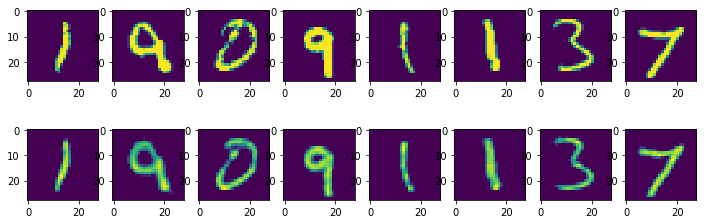

In [139]:
model = AutoEncoder(inp_size=784, hid_size=50, add_drop = False)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = train(model, optimizer, train_loader, test_loader, loss_param = {'lam':1e-4, 'reg':'l1', 'loss':'l2'}, n_ep  = 20)